# EDA for EIA Data

## Load in libraries

In [1239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', None)

In [1240]:
gen_df = pd.read_parquet('../data/energy_demand.parquet')
weather_df = pd.read_parquet('../data/weather.parquet')
XLE_df = pd.read_csv('../data/XLE.csv')
holidays = pd.read_csv('../data/holiday.csv')

In [1241]:
gen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275417 entries, 0 to 275416
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   period           275417 non-null  object 
 1   respondent       275417 non-null  object 
 2   respondent-name  275417 non-null  object 
 3   type-name        275417 non-null  object 
 4   value            274951 non-null  float64
 5   value-units      275417 non-null  object 
 6   year             275417 non-null  int32  
 7   month            275417 non-null  int32  
 8   days             275417 non-null  int32  
 9   hour             275417 non-null  int32  
 10  quarter          275417 non-null  int32  
 11  dayofyear        275417 non-null  int32  
dtypes: float64(1), int32(6), object(5)
memory usage: 18.9+ MB


In [1242]:
gen_df['respondent-name'] = gen_df['respondent-name'].replace('Florida', 'Florida Power and Light')

In [1243]:
gen_df['period'] = pd.to_datetime(gen_df.period)

# Create a new column to merge weather data on
- merge on period and name

In [1244]:
gen_df['name'] = gen_df['respondent-name']

In [1245]:
gen_df['name'].value_counts()

name
California Independent System Operator         68872
New York Independent System Operator           68866
Florida Power and Light                        68862
Electric Reliability Council of Texas, Inc.    68817
Name: count, dtype: int64

In [1246]:
respondents =['Electric Reliability Council of Texas, Inc.' ,
              'New York Independent System Operator',
              'Florida Power and Light' ,
               'California Independent System Operator',]

In [1247]:
weather_df['name'].value_counts()

name
new york city          73127
Los Angeles            73127
Tampa                  73127
The city of el paso    73127
Name: count, dtype: int64

In [1248]:
gen_df['name'] = gen_df['name'].replace(respondents[3], 'Los Angeles')
gen_df['name'] = gen_df['name'].replace(respondents[2], 'Tampa')
gen_df['name'] = gen_df['name'].replace(respondents[0], 'The city of el paso')
gen_df['name'] = gen_df['name'].replace(respondents[1], 'new york city')

In [1249]:
gen_df.head()

,period,respondent,respondent-name,type-name,value,value-units,year,month,days,hour,quarter,dayofyear,name
0,2015-07-01 09:00:00,CISO,California Independent System Operator,Demand,28989.0,megawatthours,2015,7,4,9,3,182,Los Angeles
1,2015-07-01 10:00:00,CISO,California Independent System Operator,Demand,27416.0,megawatthours,2015,7,4,10,3,182,Los Angeles
2,2015-07-01 11:00:00,CISO,California Independent System Operator,Demand,26388.0,megawatthours,2015,7,4,11,3,182,Los Angeles
3,2015-07-01 12:00:00,CISO,California Independent System Operator,Demand,25661.0,megawatthours,2015,7,4,12,3,182,Los Angeles
4,2015-07-01 13:00:00,CISO,California Independent System Operator,Demand,25845.0,megawatthours,2015,7,4,13,3,182,Los Angeles


In [1250]:
energy_df = pd.merge(gen_df,weather_df, how='inner', on=['name','period'],suffixes=('','2'))

In [1251]:
energy_df.shape

(274973, 36)

In [1252]:
XLE_df = XLE_df.set_index('Date')
XLE_df.index = pd.to_datetime(XLE_df.index)
XLE_df = XLE_df[['Adj Close']].copy()
XLE_df['year'] = XLE_df.index.year
XLE_df['dayofyear'] = XLE_df.index.dayofyear

In [1253]:
XLE_df.sort_index(inplace=True)

In [1254]:
XLE_df['Adj_Close_30D_lag'] = XLE_df['Adj Close'].shift(freq='28D')
XLE_df['Adj_Close_60D_lag'] = XLE_df['Adj Close'].shift(freq='56D')

In [1255]:
energy_df = pd.merge(energy_df,XLE_df,how='left', on=['year','dayofyear'])

In [1256]:
holidays =holidays.drop('Date',axis=1)

In [1257]:
energy_df = pd.merge(energy_df,holidays, how='left', on=['year','dayofyear'])

In [1258]:
energy_df.shape

(275645, 40)

In [1259]:
energy_df[energy_df['period']== '2015-07-04']

,period,respondent,respondent-name,type-name,value,value-units,year,month,days,hour,...,year2,month2,days2,hour2,quarter2,dayofyear2,Adj Close,Adj_Close_30D_lag,Adj_Close_60D_lag,Holiday
63,2015-07-04,CISO,California Independent System Operator,Demand,35519.0,megawatthours,2015,7,7,0,...,2015,7,7,0,3,185,NaN,NaN,NaN,Independence Day
68994,2015-07-04,ERCO,"Electric Reliability Council of Texas, Inc.",Demand,52732.0,megawatthours,2015,7,7,0,...,2015,7,7,0,3,185,NaN,NaN,NaN,Independence Day
137869,2015-07-04,NYIS,New York Independent System Operator,Demand,19525.0,megawatthours,2015,7,7,0,...,2015,7,7,0,3,185,NaN,NaN,NaN,Independence Day
206792,2015-07-04,FLA,Florida Power and Light,Demand,35654.0,megawatthours,2015,7,7,0,...,2015,7,7,0,3,185,NaN,NaN,NaN,Independence Day


# Check for nulls
- use pandas bfill to fill in missing data
- change period to datetime
- filer data
- change column names

In [1261]:
energy_df.isna().sum()

period                    0
respondent                0
respondent-name           0
type-name                 0
value                   467
value-units               0
year                      0
month                     0
days                      0
hour                      0
quarter                   0
dayofyear                 0
name                      0
temp                      0
feelslike                 0
dew                       0
humidity                  0
precip                    0
precipprob                0
snow                      0
snowdepth                 0
windspeed                 0
winddir                   0
sealevelpressure          0
cloudcover                0
visibility                0
solarradiation         1239
uvindex                1239
conditions                0
icon                      0
year2                     0
month2                    0
days2                     0
hour2                     0
quarter2                  0
dayofyear2          

In [1262]:
energy_df['value'] = energy_df['value'].bfill()
energy_df['solarradiation'] = energy_df['solarradiation'].bfill()
energy_df['uvindex'] = energy_df['uvindex'].bfill()
energy_df['snow'] = energy_df['snow'].bfill()
energy_df['Adj Close'] = energy_df['Adj Close'].bfill()
energy_df['Adj_Close_30D_lag'] = energy_df['Adj Close'].bfill()
energy_df['Adj_Close_60D_lag'] = energy_df['Adj Close'].bfill()

In [1263]:
energy_df = energy_df.set_index('period')

In [1264]:
energy_df.index = pd.to_datetime(energy_df.index)

In [1265]:
energy_df.columns

Index(['respondent', 'respondent-name', 'type-name', 'value', 'value-units',
       'year', 'month', 'days', 'hour', 'quarter', 'dayofyear', 'name', 'temp',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snow',
       'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'uvindex', 'conditions', 'icon',
       'year2', 'month2', 'days2', 'hour2', 'quarter2', 'dayofyear2',
       'Adj Close', 'Adj_Close_30D_lag', 'Adj_Close_60D_lag', 'Holiday'],
      dtype='object')

In [1266]:
columns = ['respondent-name','value',
        'year', 'month', 'days', 'hour', 'quarter', 'dayofyear',
        'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'uvindex', 'conditions',
       'icon','Adj Close', 'Adj_Close_30D_lag', 'Adj_Close_60D_lag', 'Holiday']

In [1267]:
energy_df = energy_df[columns].copy()

In [1268]:
energy_df.rename(columns={'respondent-name':'respondent',}, inplace=True)

In [1269]:
energy_df = pd.get_dummies(energy_df, columns=['conditions','icon','Holiday'], drop_first=True, dtype=float)

In [1270]:
energy_df.shape

(275645, 83)

In [1271]:
energy_df.shape

(275645, 83)

In [1272]:
energy_df.head()

,respondent,value,year,month,days,hour,quarter,dayofyear,temp,feelslike,...,Holiday_New Year's Day (substitute),Holiday_New Year's Eve,Holiday_Presidents' Day,Holiday_St. Patrick's Day,Holiday_Super Tuesday,Holiday_Tax Day,Holiday_Thanksgiving Day,Holiday_Valentine's Day,Holiday_Veterans Day,Holiday_Veterans Day (substitute)
period,,,,,,,,,,,,,,,,,,,,,
2015-07-01 09:00:00,California Independent System Operator,28989.0,2015,7,4,9,3,182,73.9,73.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 10:00:00,California Independent System Operator,27416.0,2015,7,4,10,3,182,74.3,74.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 11:00:00,California Independent System Operator,26388.0,2015,7,4,11,3,182,76.7,76.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 12:00:00,California Independent System Operator,25661.0,2015,7,4,12,3,182,81.6,82.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 13:00:00,California Independent System Operator,25845.0,2015,7,4,13,3,182,82.6,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


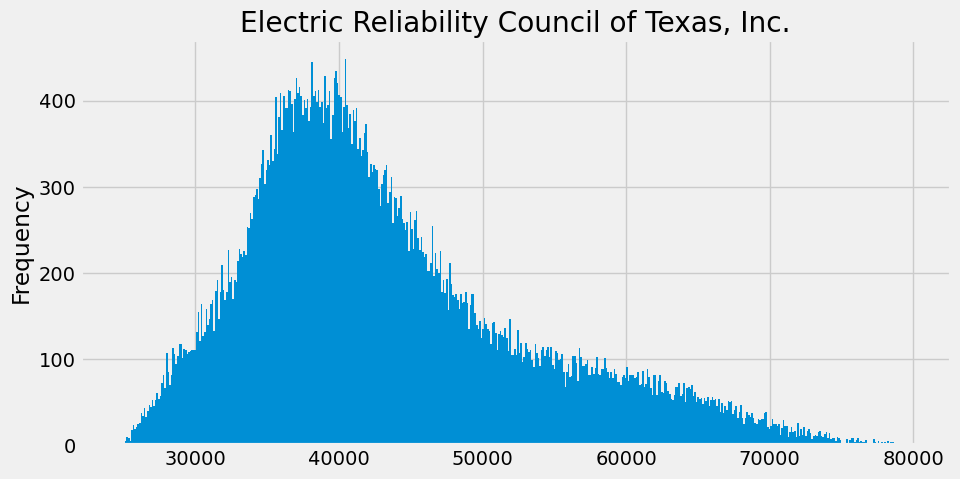

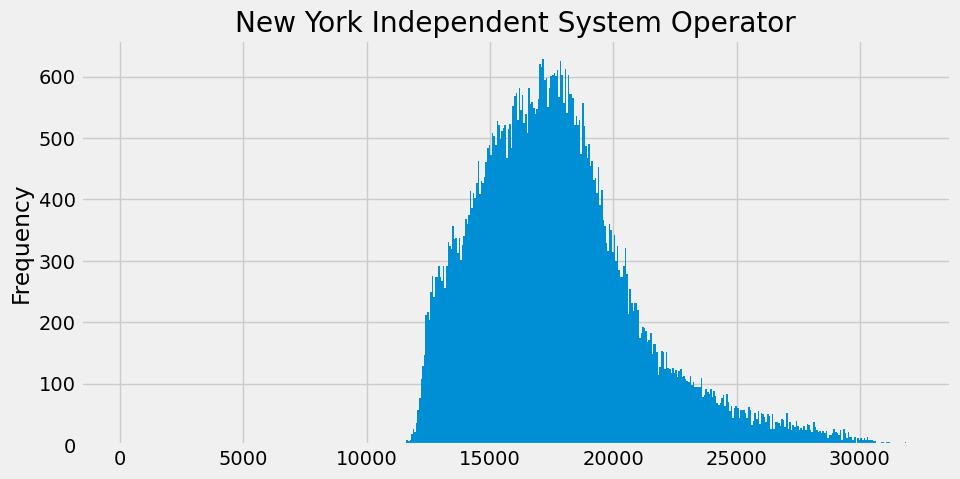

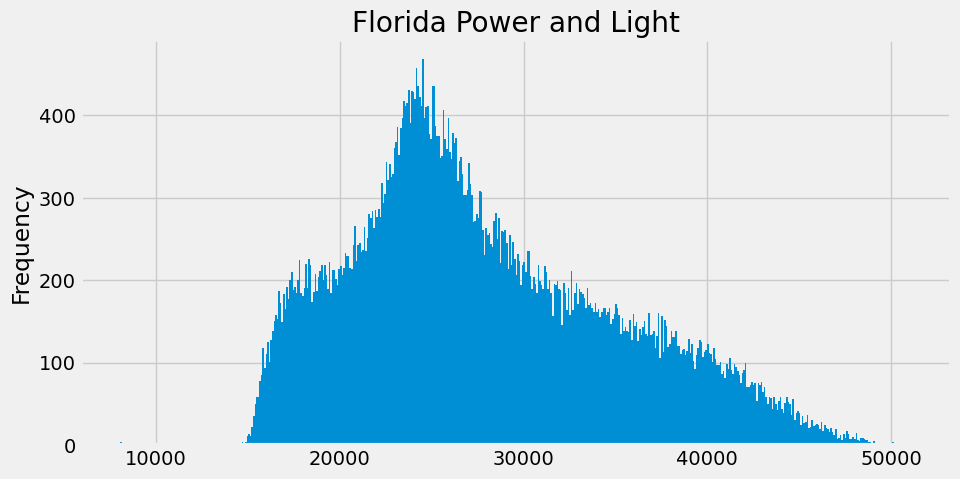

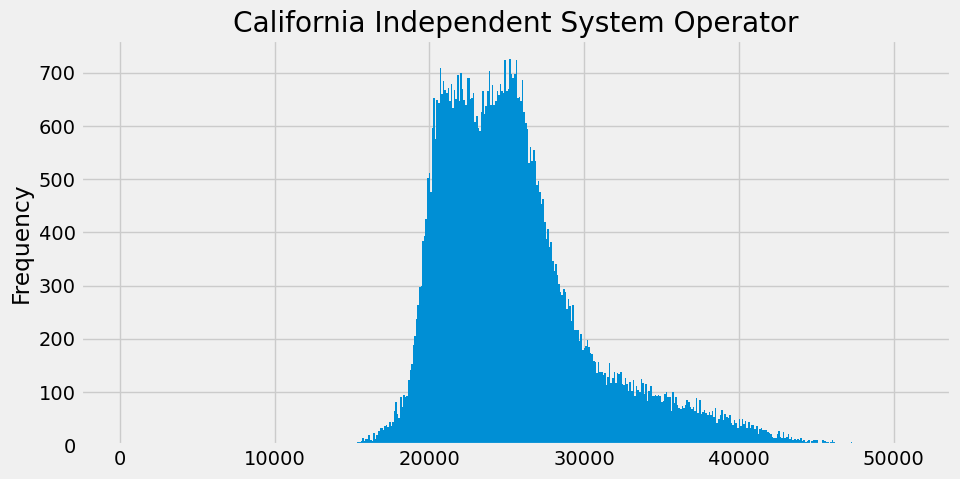

In [1273]:
for res in respondents:
    fig, ax = plt.subplots(figsize=(10,5))
    ax = energy_df.query(f"respondent == '{res}' ")['value'].plot(kind='hist', bins =500, title =f'{res}')

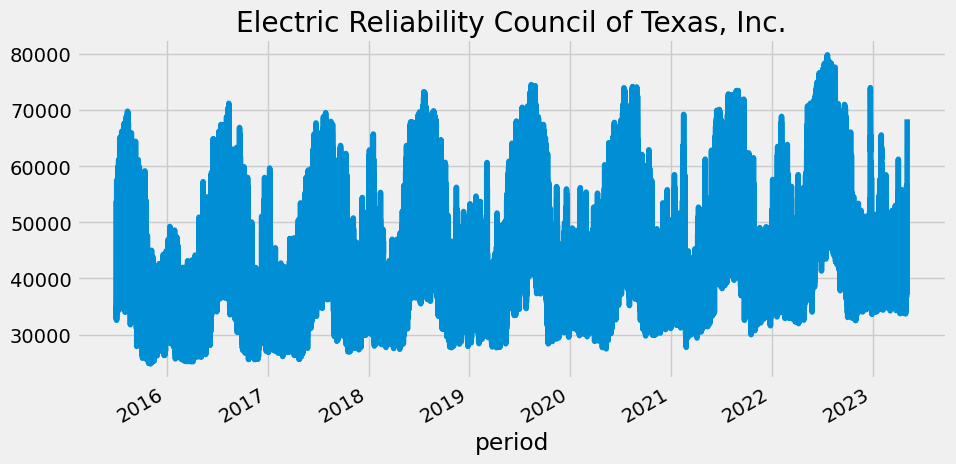

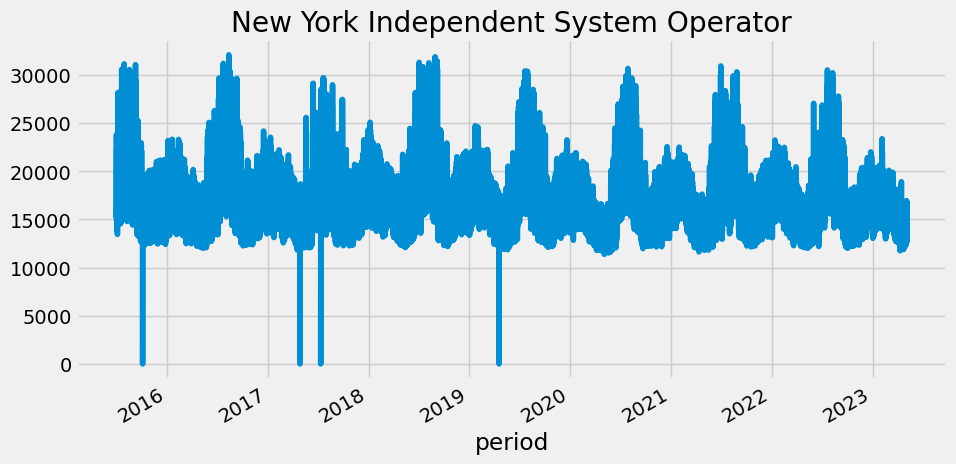

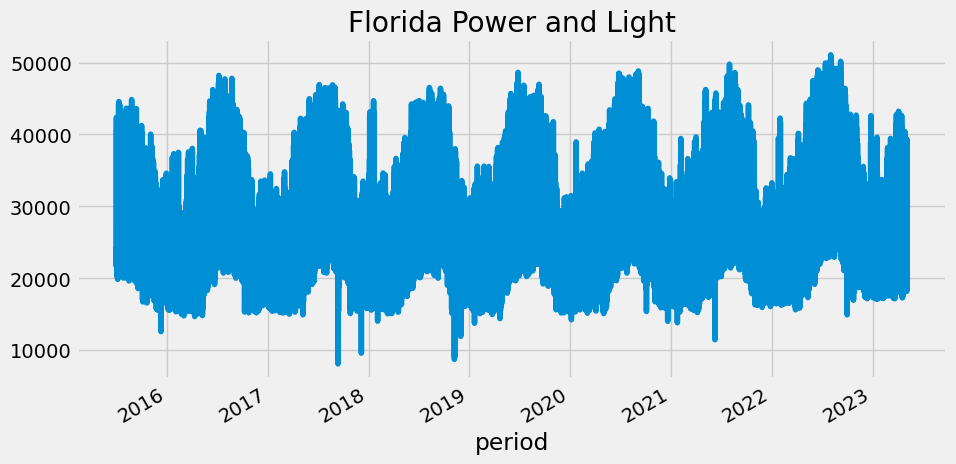

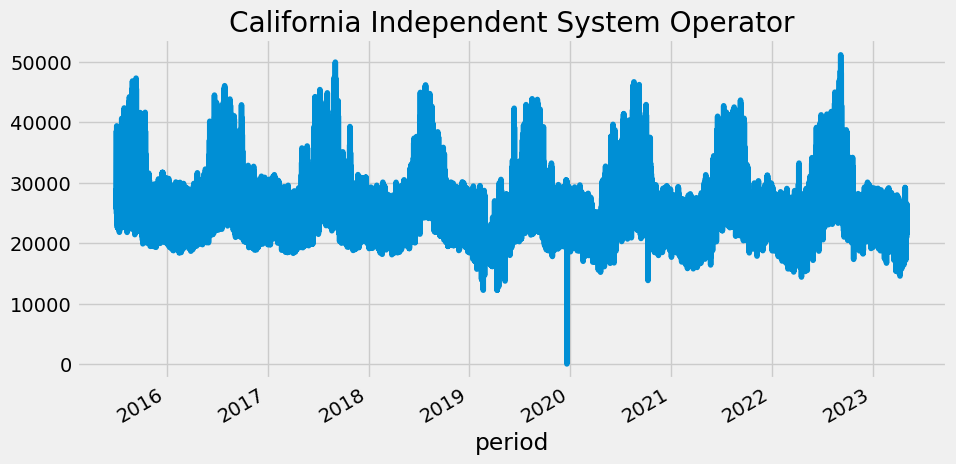

In [1274]:
for res in respondents:
    fig, ax = plt.subplots(figsize=(10,5))
    ax = energy_df.query(f"respondent == '{res}' ")['value'].plot(title =f'{res}')

In [1275]:
generation_NY = energy_df.query("respondent== 'New York Independent System Operator' and value > 7500 ").copy()
generation_Florida = energy_df.query("respondent == 'Florida Power and Light' and value >10000 ").copy()
generation_California = energy_df.query("respondent ==  'California Independent System Operator' and value >8000").copy()
generation_Texas = energy_df.query("respondent ==  'Electric Reliability Council of Texas, Inc.' and value <80000 ").copy()

In [1276]:
generation_NY['Energy_30D_AVG'] = generation_NY['value'].rolling(720).mean()
generation_Florida['Energy_30D_AVG'] = generation_Florida['value'].rolling(720).mean()
generation_California['Energy_30D_AVG'] = generation_California['value'].rolling(720).mean()
generation_Texas['Energy_30D_AVG'] = generation_Texas['value'].rolling(720).mean()

In [1281]:
generation_NY.dropna(inplace=True)
generation_Florida.dropna(inplace=True)
generation_California.dropna(inplace=True)
generation_Texas.dropna(inplace=True)

In [1283]:
generation_Texas.shape

(68155, 84)

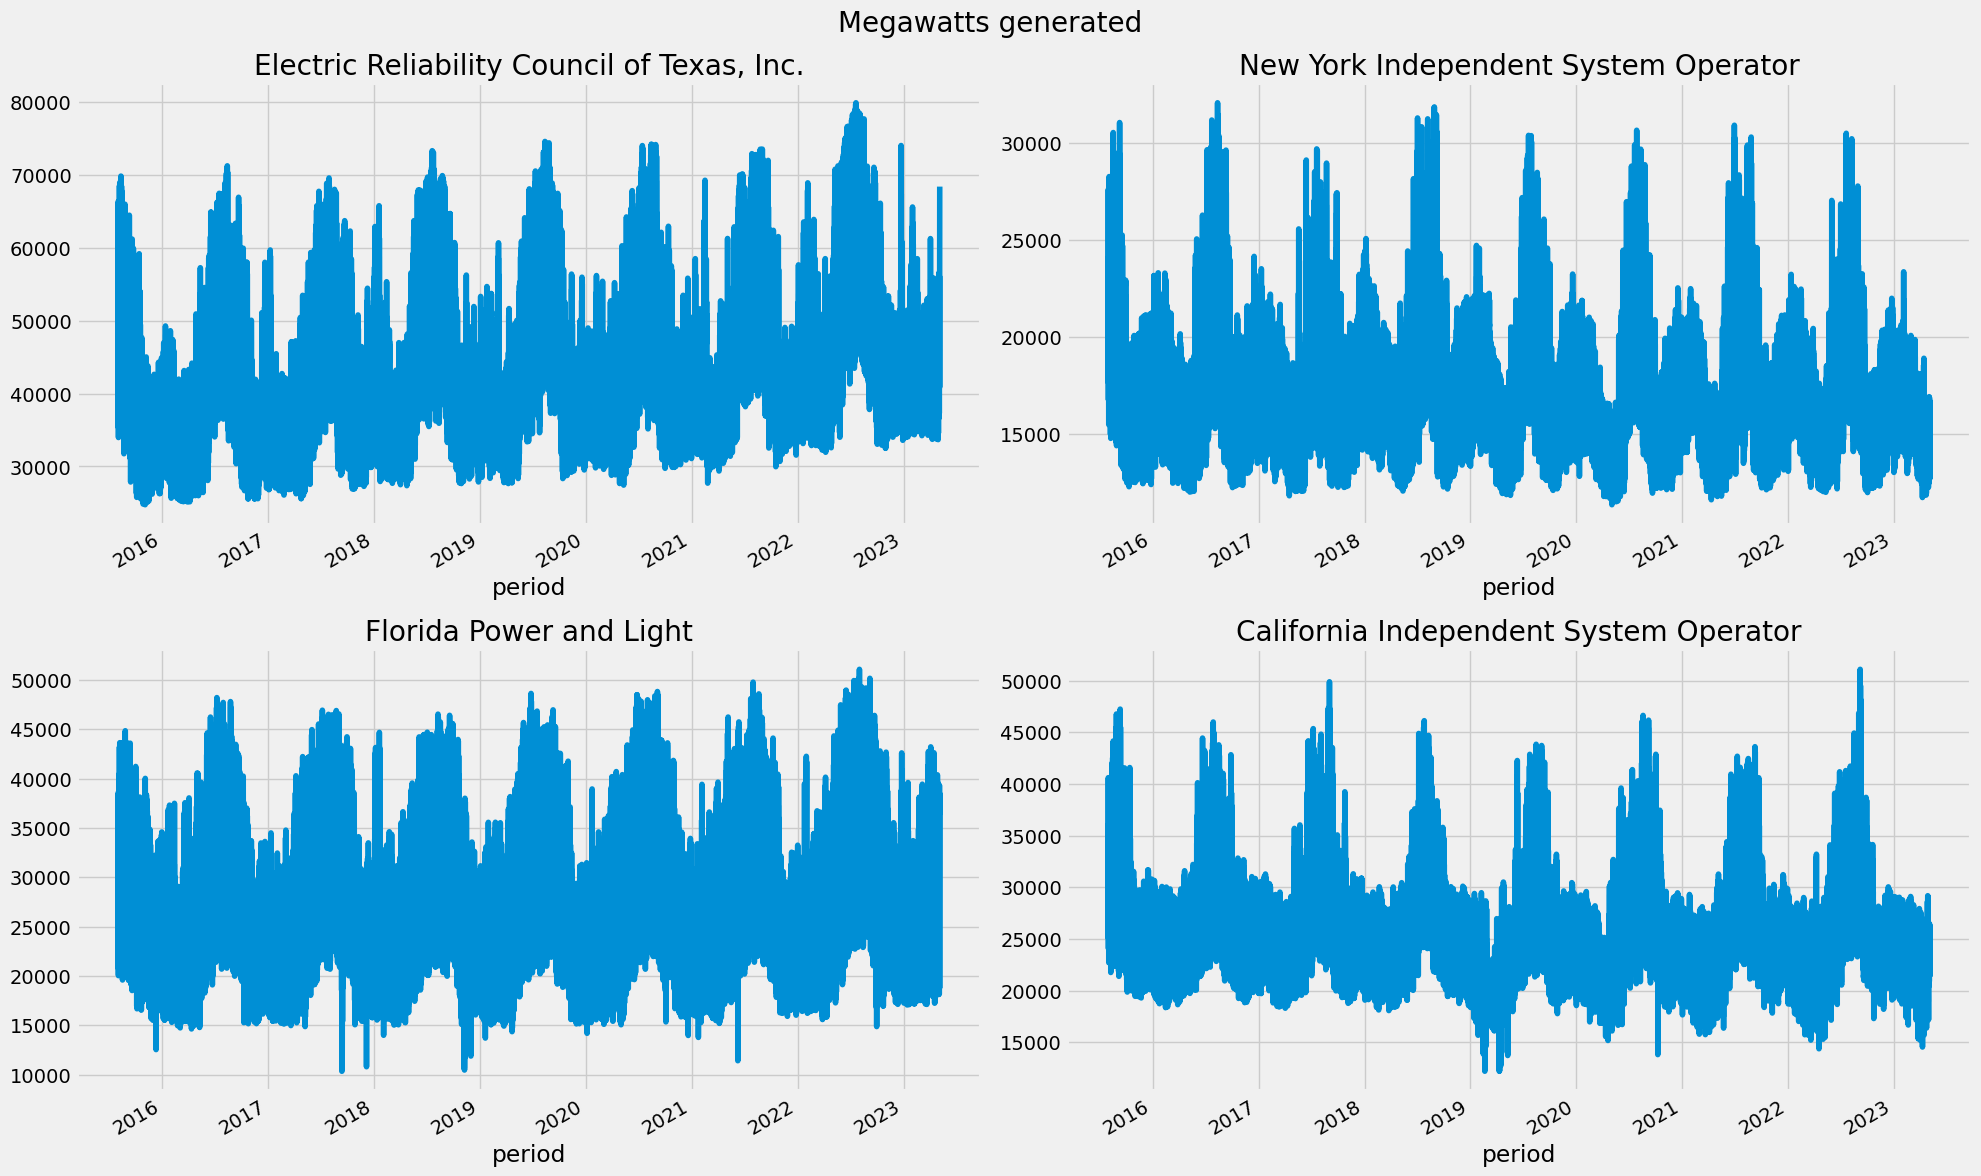

In [1284]:
fig, ax = plt.subplots(2,2,figsize=(20,12))
generation_Texas['value'].plot(ax=ax[0, 0], title =respondents[0])
generation_NY['value'].plot(ax=ax[0,1], title = respondents[1])
generation_Florida['value'].plot(ax=ax[1, 0], title =respondents[2])
generation_California['value'].plot(ax=ax[1, 1], title =respondents[3])
fig.suptitle("Megawatts generated", fontsize=20)
plt.tight_layout(pad=1)
plt.show()

In [1285]:
def create_box_plot(frequency= 'month'):
    frequency= frequency.lower()
    fig, ax = plt.subplots(2,2 ,figsize=(20,12))
    sns.boxplot(data=generation_Texas, x=frequency, y='value', palette='Blues', ax=ax[0,0], width=.4, linewidth=.8, fliersize=4)
    ax[0,0].set_title(respondents[0])
    sns.boxplot(data=generation_NY,x=frequency, y='value', palette='Blues', ax=ax[0,1],width=.4, linewidth=.8, fliersize=4)
    ax[0,1].set_title(respondents[1])
    sns.boxplot(data=generation_Florida, x=frequency, y='value', palette='Blues', ax=ax[1,0], width=.4, linewidth=.8, fliersize=4)
    ax[1,0].set_title(respondents[2])
    sns.boxplot(data=generation_California, x=frequency, y='value', palette='Blues', ax=ax[1,1], width=.4, linewidth=.8, fliersize=4)
    ax[1,1].set_title(respondents[3])
    plt.tight_layout(pad=2)
    plt.show()

In [1286]:
# hour = create_box_plot('hour')

In [1287]:
# quarter = create_box_plot('quarter')

In [1288]:
# month = create_box_plot('month')

In [1289]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

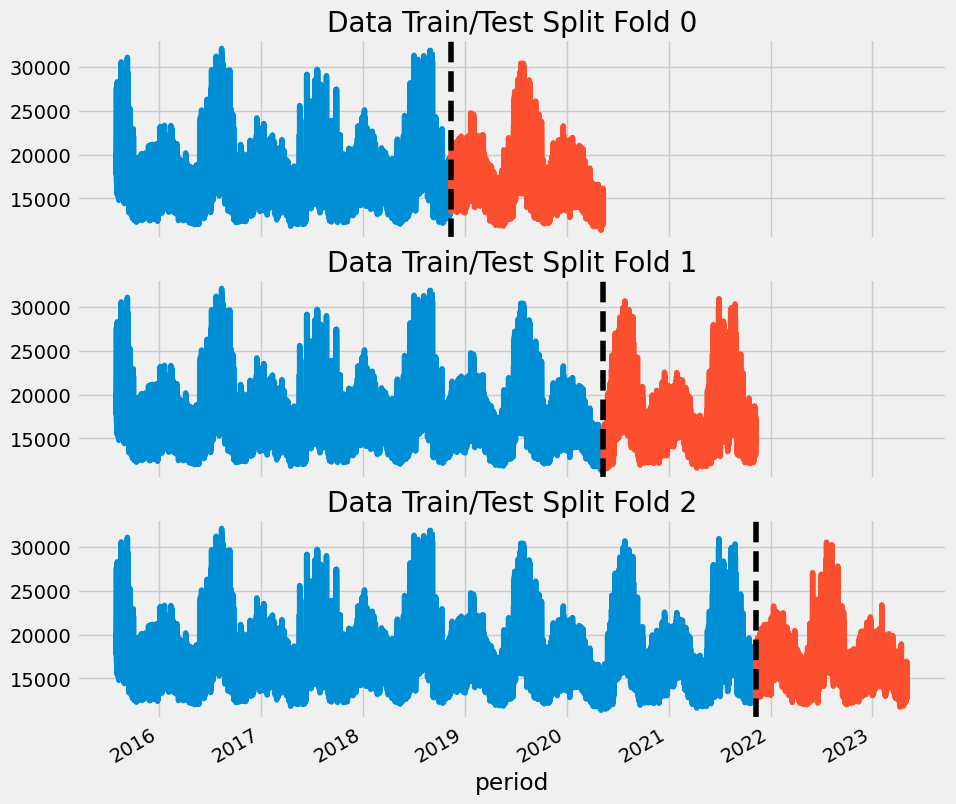

In [1290]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True)
tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
fold = 0
for train_idx, val_idx in tss.split(generation_NY):
    train = generation_NY.iloc[train_idx]
    test = generation_NY.iloc[val_idx]
    train['value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [1291]:
TARGET = 'value'
FEATURES = generation_NY.columns[2:]

In [1292]:
import warnings
warnings.filterwarnings('ignore')

In [1293]:
def xgb_train(df):
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                    n_estimators=8000,
                                    early_stopping_rounds=50,
                                    objective='reg:squarederror',
                                    max_depth=8,
                                    learning_rate=0.005,
                                    subsample = 0.7,
                                    reg_lambda = 5,
                                    min_child_weight =2,
                                    colsample_bytree = 0.8,
                                    random_state =0)
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=1000)
        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
    print(f'Score across folds {np.mean(scores):0.4f}')
    print(f'Fold scores:{scores}')

    return reg, X_test

In [1294]:
def create_graphs(df, X_test):
    test['prediction'] = reg.predict(X_test)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = df[['value']].plot(figsize=(15, 5))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('Raw Dat and Prediction')
    plt.show()


    ax = df.loc[(df.index > '12-20-2022') & (df.index < '12-27-2022')]['value'] \
    .plot(figsize=(15, 5), title='Week Of Data')
    df.loc[(df.index > '12-20-2022') & (df.index < '12-27-2022')]['prediction'] \
        .plot()
    plt.legend(['Truth Data','Prediction'],loc='upper right')
    plt.show()

In [1295]:
def create_importance(model):
    fig, ax = plt.subplots(figsize=(10,10))
    xgb.plot_importance(model,importance_type='weight', ax=ax, show_values=False, max_num_features=30)

In [1296]:
reg, X_test =xgb_train(generation_California)

[0]	validation_0-rmse:26779.89147	validation_1-rmse:24120.26853
[704]	validation_0-rmse:1438.48035	validation_1-rmse:1919.80319
[0]	validation_0-rmse:25978.96521	validation_1-rmse:26031.34147
[1000]	validation_0-rmse:1036.84160	validation_1-rmse:1875.30516
[2000]	validation_0-rmse:767.70550	validation_1-rmse:1751.27406
[3000]	validation_0-rmse:629.68900	validation_1-rmse:1726.82617
[4000]	validation_0-rmse:532.75632	validation_1-rmse:1716.11459
[5000]	validation_0-rmse:460.21047	validation_1-rmse:1708.52735
[5606]	validation_0-rmse:425.38412	validation_1-rmse:1706.67951
[0]	validation_0-rmse:25990.89127	validation_1-rmse:25108.79771
[1000]	validation_0-rmse:1099.71558	validation_1-rmse:1776.79519
[1823]	validation_0-rmse:872.23200	validation_1-rmse:1733.99337
Score across folds 1784.3178
Fold scores:[1912.7883503185797, 1706.6405374428577, 1733.5246208887768]


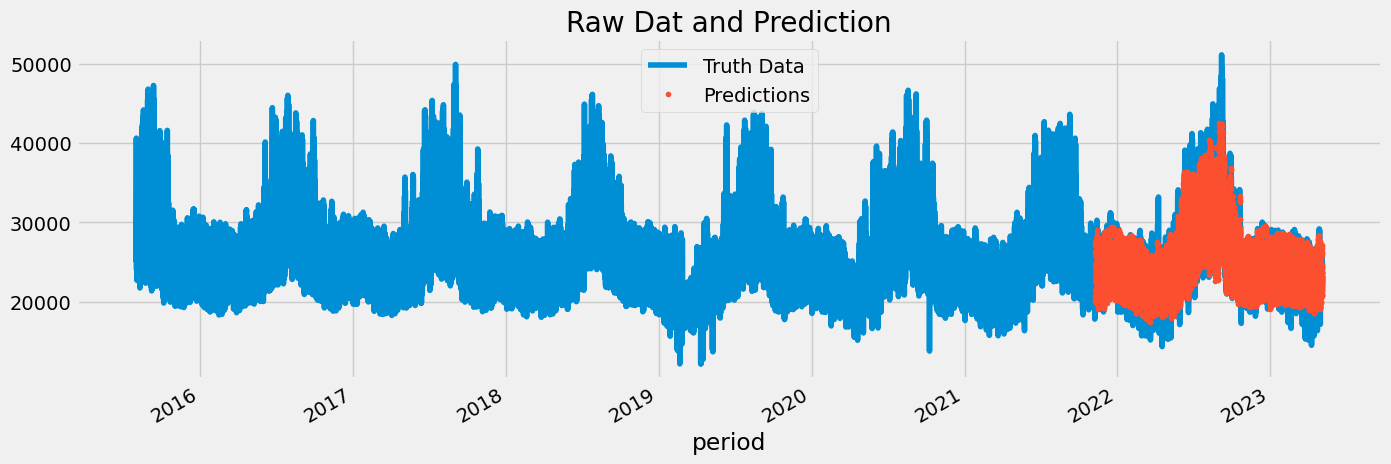

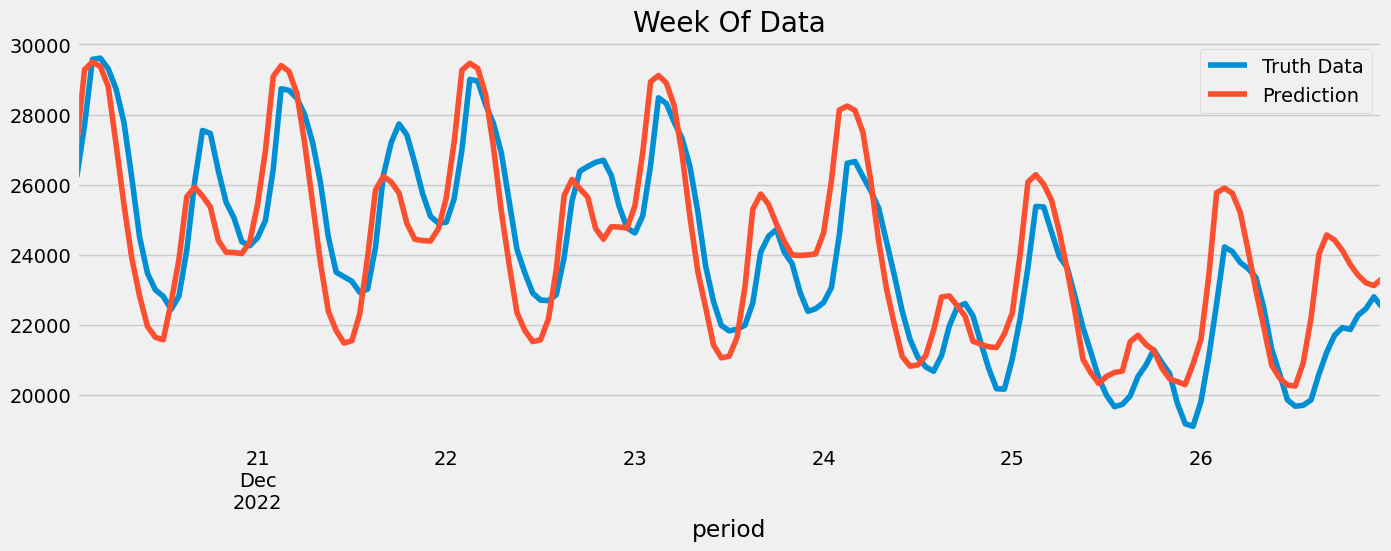

In [1297]:
create_graphs(generation_California,X_test=X_test)

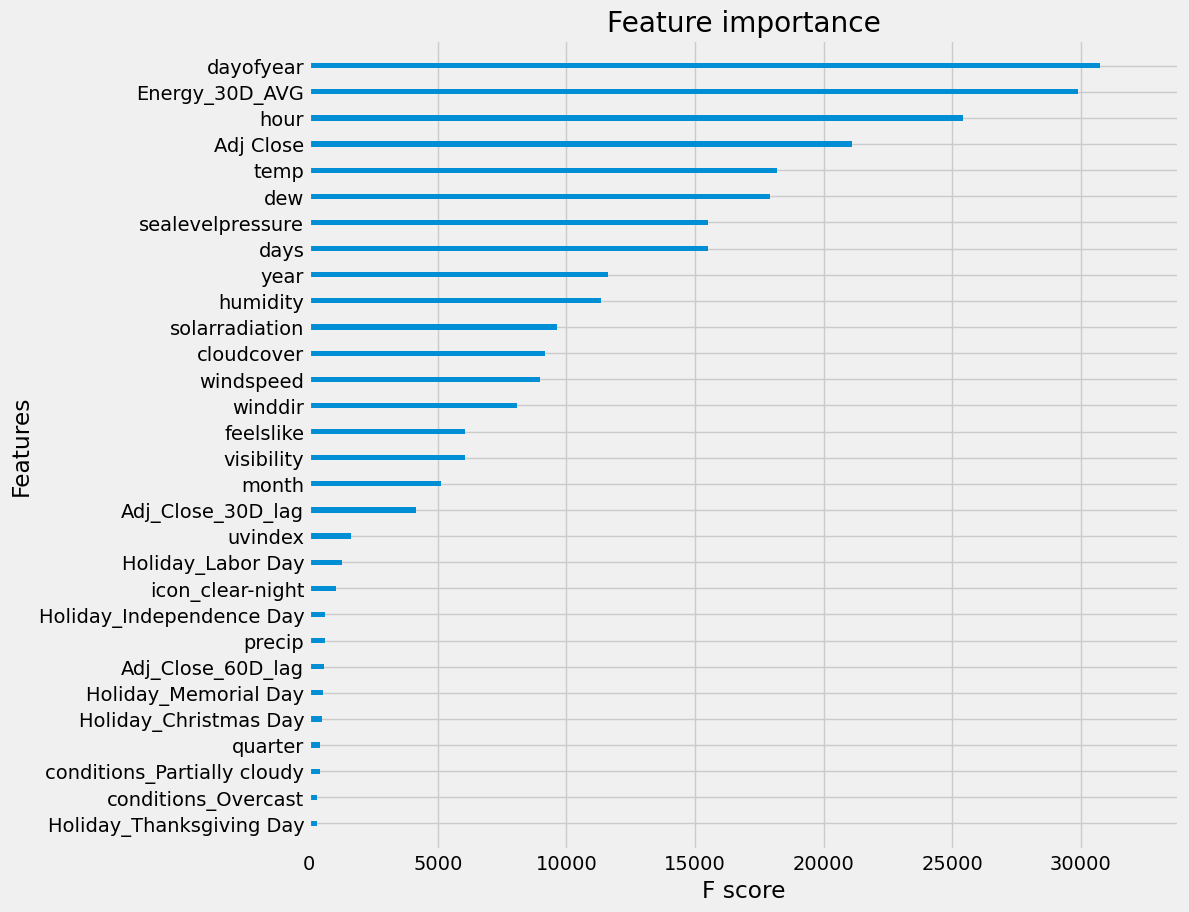

In [1298]:
create_importance(reg)

In [1040]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2021-11-29    124.714803
2021-11-09    147.878662
2022-01-18    164.547892
2023-01-10    169.994222
2021-12-28    170.331502
2022-01-02    175.697632
2023-04-07    177.553182
2022-12-31    177.827230
2022-12-18    178.459473
2022-12-07    178.685384
Name: error, dtype: float64